<a href="https://colab.research.google.com/github/KimaniKibuthu/Competitions/blob/main/Microsoft_Rice_Disease_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Microsoft Rice Disease Challenge
The objective of this challenge is to predict the disease of a rice plant in RGB and Infrared images.



# Libraries & Functions
Import the necessary libraries and useful functions.

In [1]:
# Libraries

import os
import zipfile
import requests
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Modelling
from tensorflow.keras import Sequential, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D 

# Data Obtainance & Exploration
Obtain the data.

In [2]:
# Mount drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Data url and token
data_url = "https://api.zindi.africa/v1/competitions/microsoft-rice-disease-classification-challenge/files/Images.zip" # url
token = {'auth_token': 'PeY2CaT4Ko2hTf82wwpceYH1'} 
file_name = '/content/drive/MyDrive/Microsoft Rice Challenge/images.zip'

In [4]:
# Function to download data
def zindi_data_downloader(url, token, file_name):
    # Get the competition data
    competition_data = requests.post(url = data_url, data= token, stream=True)
    
    # Progress bar monitor download
    pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
    # Create and Write the data to colab drive in chunks
    handle = open(file_name, "wb")
    for chunk in competition_data.iter_content(chunk_size=512): # Download the data in chunks
        if chunk: # filter out keep-alive new chunks
          handle.write(chunk)
        pbar.update(len(chunk))
    handle.close()
    pbar.close()

In [8]:
# download the data
zindi_data_downloader(data_url, token, file_name)

/content/drive/MyDrive/Microsoft Rice Challenge/images.zip:   0%|          | 0.00/10.2G [00:00<?, ?B/s]

In [11]:
# Unzip the data
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Microsoft Rice Challenge/images.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/Microsoft Rice Challenge/images')

**Get and Explore the CSV data**


In [5]:
# Get the data
train = pd.read_csv('/content/drive/MyDrive/Microsoft Rice Challenge/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Microsoft Rice Challenge/Test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Microsoft Rice Challenge/SampleSubmission.csv')


In [6]:
# Explore train
print(train.head())
print('-' * 50)
print(test.head())

                Image_id  Label
0      id_004wknd7qd.jpg  blast
1  id_004wknd7qd_rgn.jpg  blast
2      id_005sitfgr2.jpg  brown
3  id_005sitfgr2_rgn.jpg  brown
4      id_00stp9t6m6.jpg  blast
--------------------------------------------------
                Image_id
0      id_00vl5wvxq3.jpg
1  id_00vl5wvxq3_rgn.jpg
2      id_01hu05mtch.jpg
3  id_01hu05mtch_rgn.jpg
4      id_030ln10ewn.jpg


In [7]:
# View info
print(train.info())
print('-' * 50)
print(test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5340 entries, 0 to 5339
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_id  5340 non-null   object
 1   Label     5340 non-null   object
dtypes: object(2)
memory usage: 83.6+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_id  2290 non-null   object
dtypes: object(1)
memory usage: 18.0+ KB
None


In [8]:
# Check percentage
train['Label'].value_counts(normalize=True)

blast      0.559551
brown      0.286891
healthy    0.153558
Name: Label, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


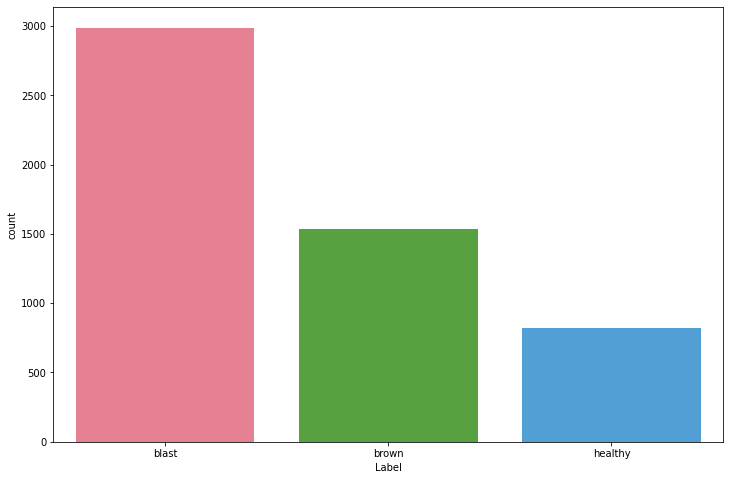

In [9]:
# Check the distribution of classes
plt.figure(figsize=(12,8))
sns.countplot(train['Label'], x='Label', palette='husl')

From these findings, we will augment the brown and healthy labels to allow the model to learn from them.

**Explore the images** 

In [10]:
def show_images(the_path, class_name, data):
    # Get images 
    print(f'{class_name}')
    # Extract 16 random images from it
    columns = data.columns
    images_temp = data.loc[data[columns[1]]==class_name]
    random_images = [np.random.choice(images_temp[columns[0]].values) for i in range(8)]
    
    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
  
    for i in range(8):
        plt.subplot(2,4,i+1)
        img = plt.imread(os.path.join(the_path, random_images[i]))
        
        try:
          plt.imshow(img, cmap='gray')
          #plt.axis('off')
        except FileNotFoundError:
          pass

    # Adjust subplot parameters to give specified padding
    plt.tight_layout() 

brown


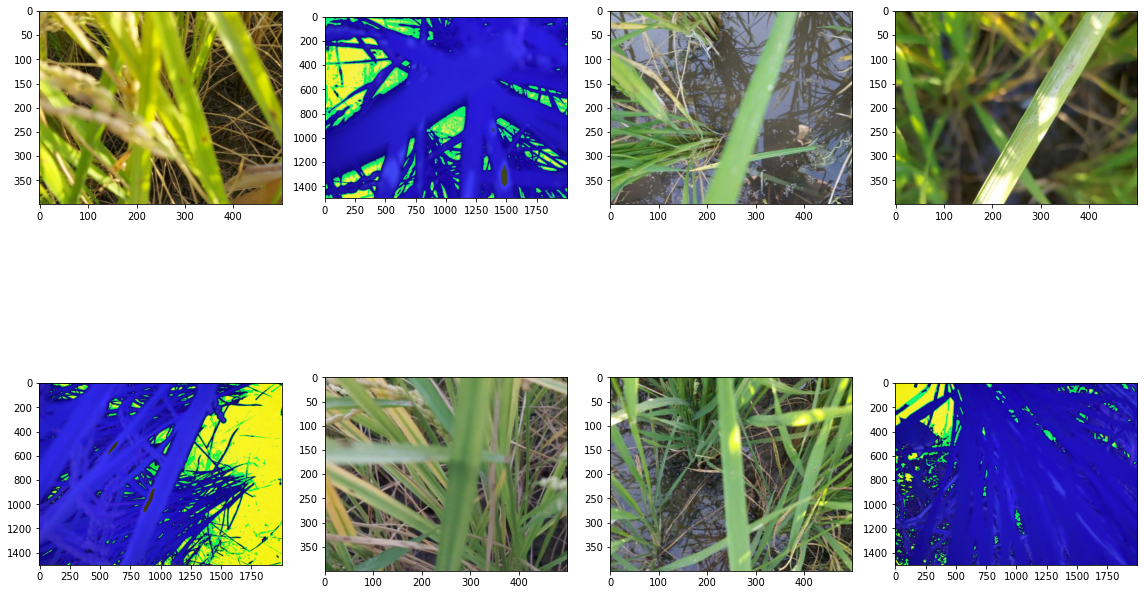

In [11]:
# Show brown images
show_images('/content/drive/MyDrive/Microsoft Rice Challenge/images', 
            'brown',
            train)

blast


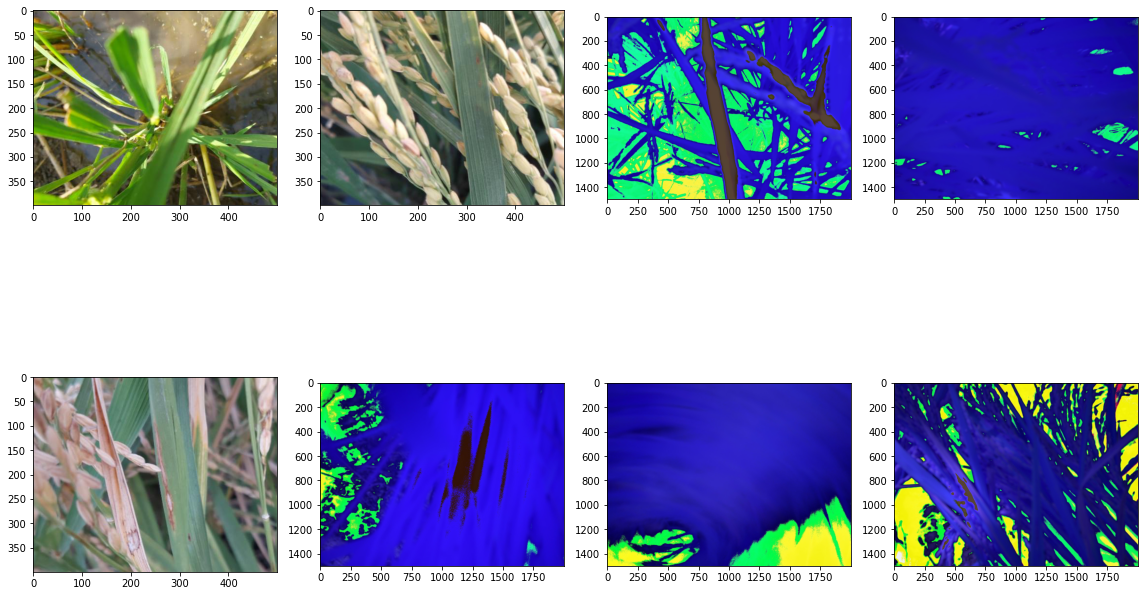

In [12]:

# Show blast images
show_images('/content/drive/MyDrive/Microsoft Rice Challenge/images', 
            'blast',
            train)

healthy


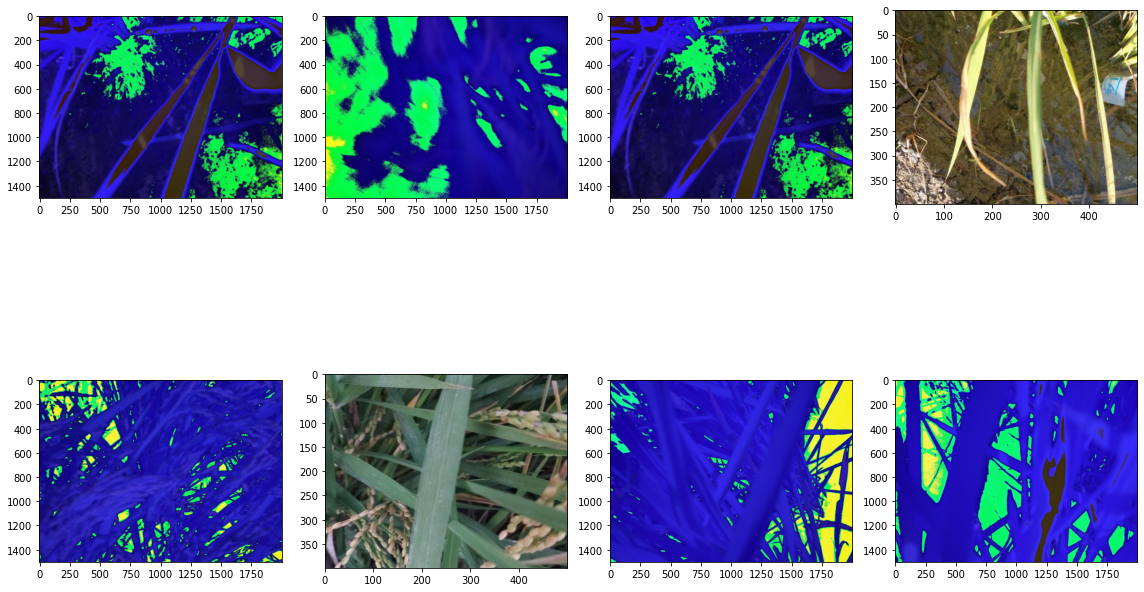

In [13]:
# Show normal images
show_images('/content/drive/MyDrive/Microsoft Rice Challenge/images', 
            'healthy',
            train)

# Data Preprocessing
Preprocess the data to ensure that it is able to

**Split Data**

In [14]:
# split into train and validation
X = train.drop('Label', axis=1)
y = train['Label']

trainset, valset = train_test_split(train,
                                    train_size=0.9,
                                    random_state=42,
                                    stratify=train['Label'])


## Image Data Augmentation


In [15]:

# Instantiate objects
train_augmentor = ImageDataGenerator(rescale=1./255)
val_augmentor = ImageDataGenerator(rescale=1./255)



In [16]:
# Instantiate Data Generators
train_generator = train_augmentor.flow_from_dataframe(trainset,
                                                  '/content/drive/MyDrive/Microsoft Rice Challenge/images',
                                                  x_col='Image_id',
                                                  y_col='Label',
                                                  target_size=(250,250),
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=True
                                                  )

val_generator = val_augmentor.flow_from_dataframe(valset,
                                                  '/content/drive/MyDrive/Microsoft Rice Challenge/images',
                                                  x_col='Image_id',
                                                  y_col='Label',
                                                  target_size=(250,250),
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=False
                                                  )

Found 4806 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


# Modelling

Create model

In [17]:
def create_model():
  
  # Build model
  inception =InceptionV3(include_top=False, 
                          input_shape=(250, 250, 3))
  
  for layer in inception.layers:
    layer.trainable = True

  model = Sequential([
                      
                      inception,
                      GlobalAveragePooling2D(),
                      #Flatten(),
                      Dense(256, activation = 'relu'),
                      Dense(32, activation = 'relu'),

                      #Dropout(0.5),
                      Dense(3, activation = 'softmax')
  ])

  # Instantiate learning rate and optimizer
  loss = tf.keras.losses.BinaryCrossentropy(from_logits = False,
                                                   label_smoothing=0.01,
                                                   name='categorical_crossentropy' )

  adam = tf.keras.optimizers.Adam(0.0005)
  
  
  # Compile model
  model.compile(loss = loss,
                optimizer = adam,
                metrics = ['accuracy'])
  
  return model

In [18]:
def model_fitter(model):

  # instantiate callbacks
  
  early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 patience=15)

  # reduce learning rate
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
  checkpoint = tf.keras.callbacks.ModelCheckpoint('content/Best.h5', monitor='val_loss', mode = 'min' , verbose=1, save_best_only=True, save_weights_only=False)

  callbacks = [early_stopper, reduce_lr, checkpoint]

  # Train model
  history = model.fit(train_generator,
                    epochs= 5,
                    steps_per_epoch=int(np.ceil(train_generator.samples)/32),
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=int(np.ceil(val_generator.samples)/32)
                    )
  
  return history, model

In [19]:
model = create_model()

87924736/87910968 [==============================] - 1s 0us/step


In [20]:
history, model = model_fitter(model)

Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.4679 - accuracy: 0.6795
Epoch 1: val_loss improved from inf to 0.45072, saving model to content/Best.h5
150/150 [==============================] - 1176s 8s/step - loss: 0.4679 - accuracy: 0.6795 - val_loss: 0.4507 - val_accuracy: 0.7617 - lr: 5.0000e-04
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.7752
Epoch 2: val_loss did not improve from 0.45072
150/150 [==============================] - 178s 1s/step - loss: 0.3555 - accuracy: 0.7752 - val_loss: 0.7528 - val_accuracy: 0.3848 - lr: 5.0000e-04
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8016
Epoch 3: val_loss did not improve from 0.45072
150/150 [==============================] - 178s 1s/step - loss: 0.3199 - accuracy: 0.8016 - val_loss: 0.5666 - val_accuracy: 0.7227 - lr: 5.0000e-04
Epoch 4/5
150/150 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.859

In [21]:
# 
def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **accuracy**

    :param all: bool
    default=True. If true, overrides metric and plots figures of accuracy and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation accuracy',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train accuracy',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation accuracy plots',
                             xaxis_title='Epochs',
                             yaxis_title='accuracy')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['accuracy']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='accuracy',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='accuracy plot',
                             xaxis_title='Epochs',
                             yaxis_title='accuracy')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()


In [22]:
plot_interactive_figures(history, 'accuracy')